In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george

### 1. Creating a simple Gaussian model:
$$ f(t) = \alpha\  \mathrm{exp}\left[-\frac{(t-\ell)^2}{2\sigma^2} \right] $$

Amplitude $\alpha$, location $\ell$, width $\sigma^2$.
$$\alpha=-1 \quad, \quad \ell=0.1 \quad, \quad \sigma^{2}=0.4$$

In [2]:
from george.modeling import Model

class Model(Model):
    parameter_names = ("amp", "location", "log_sigma2")

    def get_value(self, t):
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))


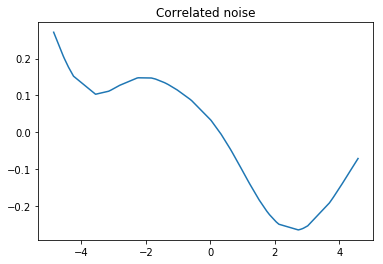

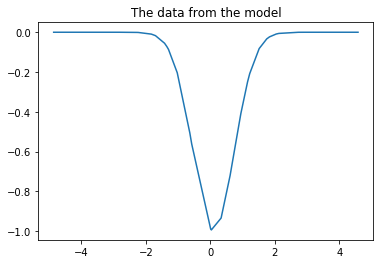

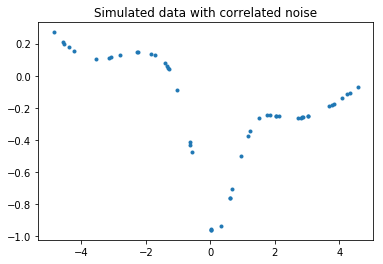

In [77]:
rng=(-5, 5)
np.random.seed(1234)
gp = george.GP(0.1*kernels.ExpSquaredKernel(3.3))
t = rng[0] + np.diff(rng) * np.sort(np.random.rand(50))
y = gp.sample(t)

plt.figure()
plt.plot(t, y)
plt.title('Correlated noise');

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
y += Model(**truth).get_value(t)

plt.figure()
plt.plot(t, Model(**truth).get_value(t))
plt.title('The data from the model');

plt.figure()
plt.plot(t, y,'.')
plt.title('Simulated data with correlated noise');

$
\text { george. kernels. ExpSquaredkernel }
$
$$
k\left(r^{2}\right)=\exp \left(-\frac{r^{2}}{2}\right)
$$

### 1.1 Simulating a dataset of 50 points with known correlated noise:

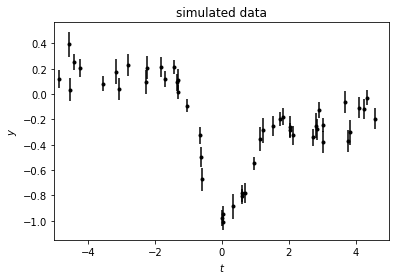

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from george import kernels

np.random.seed(1234)

def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t) # Draw samples from the prior distribution. The correlated noise
    y += Model(**params).get_value(t) # Add correlated noise to standard model
    yerr = 0.05 + 0.05 * np.random.rand(N) # The errors
    y += yerr * np.random.randn(N)
    return t, y, yerr

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
t, y, yerr = generate_data(truth, 50)

pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("simulated data");


### 2. Assuming White Noise
- Assuming the noise is uncorrelated.

$\text { The ln-likelihood function of the data }\left\{y_{n}\right\} \text { given the parameters } \theta \text { is }$

$$\ln p\left(\left\{y_{n}\right\} |\left\{t_{n}\right\},\left\{\sigma_{n}^{2}\right\}, \theta\right)=-\frac{1}{2} \sum_{n=1}^{N} \frac{\left[y_{n}-f_{\theta}\left(t_{n}\right)\right]^{2}}{\sigma_{n}^{2}}+A$$

$\text { where } A \text { doesn't depend on } \theta \text { so it is irrelevant for our purposes and } f_{\theta}(t) \text { is our model function. }$

#### 2.1 There is a trend in the data, so we model a linear trend and the Gaussian feature. Our model is
$$
f_{\theta}(t)=m t+b+\alpha \exp \left(-\frac{[t-\ell]^{2}}{2 \sigma^{2}}\right)
$$

$$
\theta=\left\{m, b, \alpha, \ell, \sigma^{2}\right\}
$$

In [78]:
class PolynomialModel(Model):
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))

#### 2.2 Fit this model using MCMC (emcee). We choose a simple uniform prior on each parameter.

Set the `PolynomialModel` as mean function in GP. 

In [79]:
model = george.GP(mean=PolynomialModel(m=0, b=0, amp=-1, location=0.1, log_sigma2=np.log(0.4)))
model.compute(t, yerr)

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

####  Run MCMC:

In [85]:
import emcee

initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000)
print('Finished.')

Running burn-in...
Running production...
Finished.


#### 2.3 Plot the results.

In [93]:
np.random.randint(len(samples), size=24) # results are from [0, `len(samples)`)

array([17196,  7247,  6742,  6486, 17281, 21108, 24627, 27141,  1756,
       17749, 29332, 26109, 26249, 20190, 27867, 27530, 23619, 30494,
        4104,  7037,  9698, 16499, 16176, 24454])

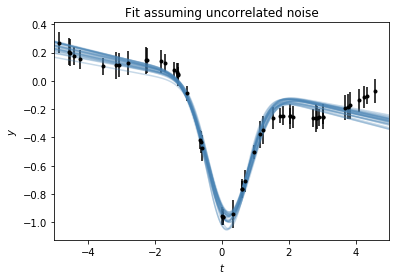

In [87]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    model.set_parameter_vector(s)
    pl.plot(x, model.mean.get_value(x), color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("Fit assuming uncorrelated noise");


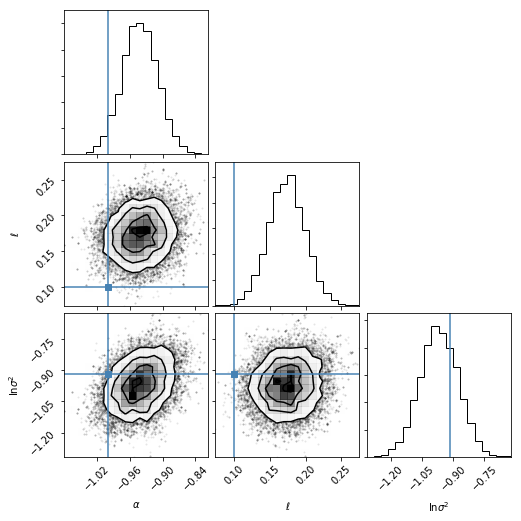

In [135]:
import corner

tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
tri_truths = [truth[k] for k in tri_cols]
tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
names = model.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

### Let's see what will happen if I input white noise in geroge.GP().

In [157]:
from george import modeling
def whitenoise(time):
    return np.log(yerr**2)

model2 = george.GP(mean=PolynomialModel(m=0, b=0, amp=-1, location=0.1, log_sigma2=np.log(0.4)), \
                   white_noise=modeling.CallableModel(whitenoise, gradient=None))
model2.compute(t,yerr)

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

In [158]:
initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000)
print('Finished.')

Running burn-in...
Running production...
Finished.


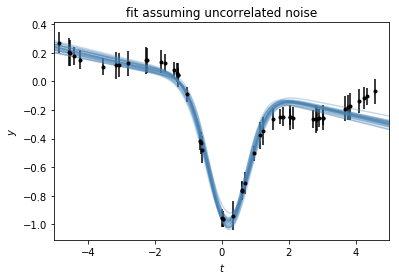

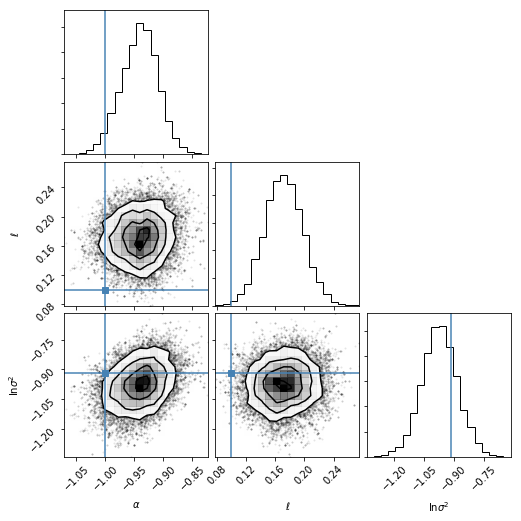

In [160]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    model.set_parameter_vector(s)
    pl.plot(x, model.mean.get_value(x), color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit assuming uncorrelated noise");

tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
tri_truths = [truth[k] for k in tri_cols]
tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
names = model.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

### 3. Using a covariance function to model the noise.

The likelihood function
$$
\ln p\left(\left\{y_{n}\right\} |\left\{t_{n}\right\},\left\{\sigma_{n}^{2}\right\}, \theta\right)=-\frac{1}{2} \boldsymbol{r}^{\mathrm{T}} K^{-1} \boldsymbol{r}-\frac{1}{2} \ln \operatorname{det} K-\frac{N}{2} \ln 2 \pi
$$
where
$$
\boldsymbol{r}=\left( \begin{array}{c}{y_{1}-f_{\theta}\left(t_{1}\right)} \\ {y_{2}-f_{\theta}\left(t_{2}\right)} \\ {\vdots} \\ {y_{N}-f_{\theta}\left(t_{N}\right)}\end{array}\right)
$$
is the residual vector and 
$$
K=\left( \begin{array}{cccc}{\sigma_{1}^{2}} & {0} & { } & {0} \\ {0} & {\sigma_{2}^{2}} & { } & {0} \\ { } & { } & {\ddots} & { } \\ {0} & {0} & { } & {\sigma_{N}^{2}}\end{array}\right)
$$

#### I choose the Expsquared kernel instead of the Matérn-3/2 function as in the tutorial.

In [150]:
kwargs = dict(**truth)
kwargs["bounds"] = dict(location=(-2, 2))
mean_model = Model(**kwargs)
gp = george.GP(np.var(y) * kernels.ExpSquaredKernel(10.0), mean=mean_model)
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()

In [151]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32s
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000)
print('Finished!')

Running first burn-in...
Running second burn-in...
Running production...
Finished!


In [166]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.556


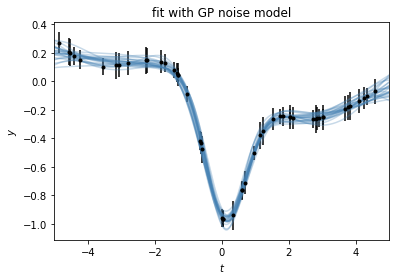

In [152]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    pl.plot(x, mu, color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit with GP noise model");

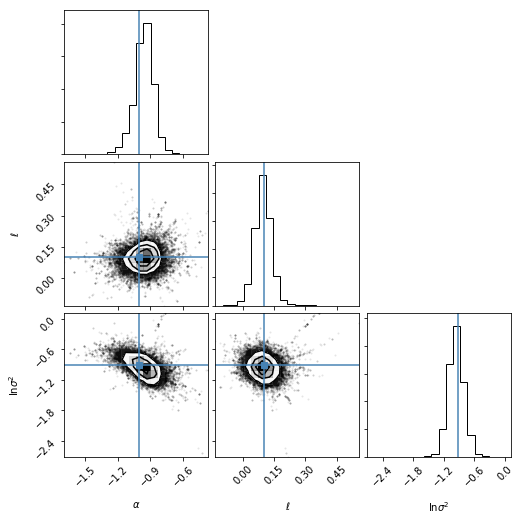

In [153]:
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

#### The corner plot using the Matérn-3/2 function.
It looks more accurate for parameter $\alpha$:
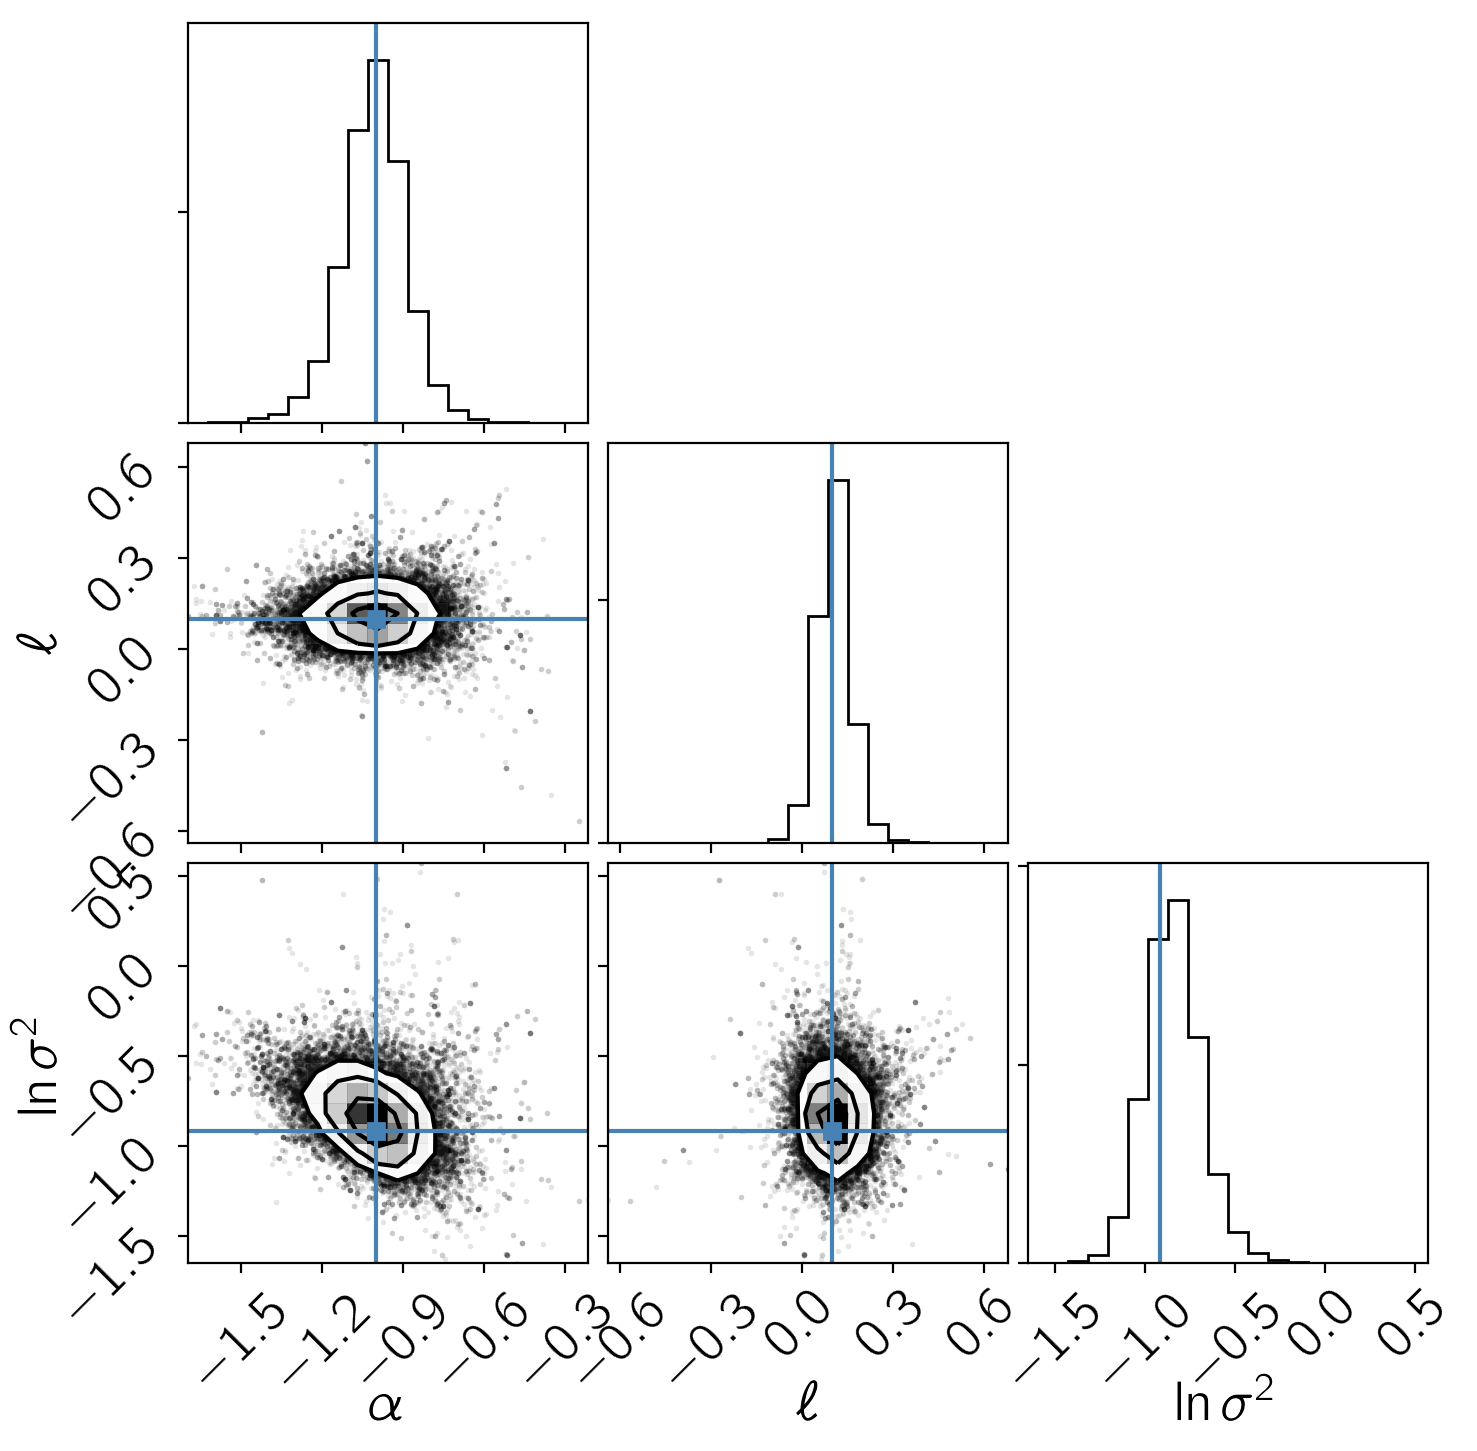

## Fitting white noise:

In [171]:
kwargs = dict(**truth)
kwargs["bounds"] = dict(location=(-2, 2))
mean_model = Model(**kwargs)
gp = george.GP(np.var(y) * kernels.ExpSquaredKernel(10.0), mean=mean_model, \
              white_noise=modeling.CallableModel(whitenoise, gradient=None))
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()
               
#-----------------
#Run MCMC              
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000)
print('Finished!')

Running first burn-in...
Running second burn-in...
Running production...
Finished!


Mean acceptance fraction: 0.533


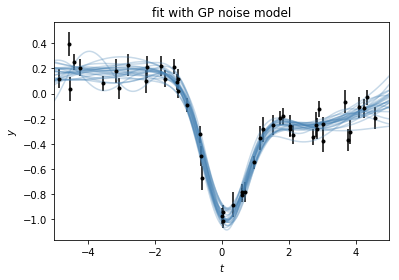

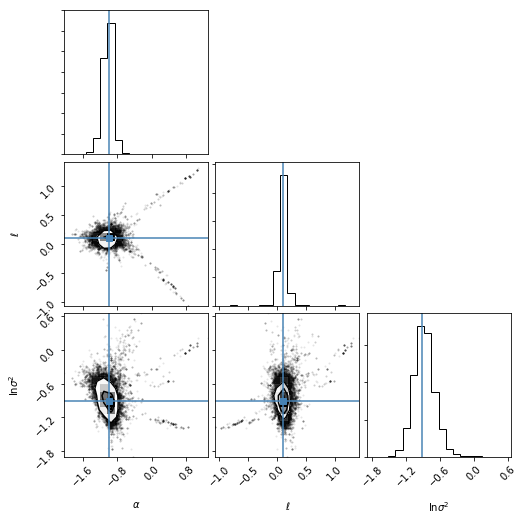

In [172]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    pl.plot(x, mu, color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit with GP noise model");


names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

In [179]:
kwargs = dict(**truth)
kwargs["bounds"] = dict(location=(-2, 2))
mean_model = Model(**kwargs)
gp = george.GP(np.var(y) * kernels.ExpSquaredKernel(10.0),fit_mean=True)
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()
               
#-----------------
#Run MCMC              
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000)
print('Finished!')

Running first burn-in...
Running second burn-in...
Running production...
Finished!


Mean acceptance fraction: 0.709


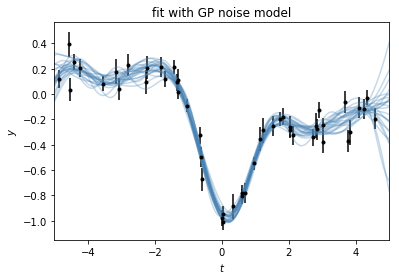

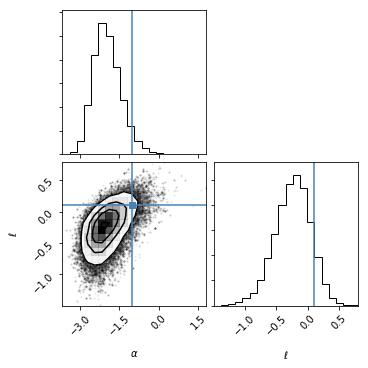

In [180]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    pl.plot(x, mu, color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit with GP noise model");


names = gp.get_parameter_names()
#inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain, truths=tri_truths, labels=tri_labels);

Reduced x^2 =